# HW 11  - Assingment 2

### vsg247

In [1]:
import os
import numpy as np
import pandas as pd
import zipfile as zp
import geopandas as gpd
import json
import shapely
import pylab as pl

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib  


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy.spatial.distance import  pdist
from sklearn.mixture import GMM

    
% matplotlib inline

## 1. get and prep the data.

### 1.a. get businesses by ZIP code data

In [2]:
# data from 1994 to 1999

i=94
while i < 100:
    filename = "zbp" + str(i) + "totals.zip"  
    
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + filename):
        os.system("curl -O ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/" + filename)
        os.system("mv " + filename + " " + os.getenv("PUIDATA"))
        print ("{0} was successfully downloaded to the PUIdata directory".format(filename))
    else:
        print ("{0} was already at the PUIdata directory".format(filename))
        
    i+=1
    


zbp94totals.zip was already at the PUIdata directory
zbp95totals.zip was already at the PUIdata directory
zbp96totals.zip was already at the PUIdata directory
zbp97totals.zip was already at the PUIdata directory
zbp98totals.zip was already at the PUIdata directory
zbp99totals.zip was already at the PUIdata directory


In [3]:
# data from 2000 and 2001

i=0
while i < 2:
    filename = "zbp0" + str(i) + "totals.zip"  
    
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + filename):
        os.system("curl -O ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/" + filename)
        os.system("mv " + filename + " " + os.getenv("PUIDATA"))
        print ("{0} was successfully downloaded to the PUIdata directory".format(filename))
    else:
        print ("{0} was already at the PUIdata directory".format(filename))
        
    i+=1

zbp00totals.zip was already at the PUIdata directory
zbp01totals.zip was already at the PUIdata directory


In [4]:
# data from 2002 to 2014

i=2
while i < 15:
    filename = "zbp" + "{0:02}".format(i) + "totals.zip"  
    
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + filename):
        os.system("curl -O ftp://ftp.census.gov/econ20" + "{0:02}/CBP_CSV/".format(i) + filename)
        os.system("mv " + filename + " " + os.getenv("PUIDATA"))
        print ("{0} was successfully downloaded to the PUIdata directory".format(filename))
    else:
        print ("{0} was already at the PUIdata directory".format(filename))
        
    i+=1

zbp02totals.zip was already at the PUIdata directory
zbp03totals.zip was already at the PUIdata directory
zbp04totals.zip was already at the PUIdata directory
zbp05totals.zip was already at the PUIdata directory
zbp06totals.zip was already at the PUIdata directory
zbp07totals.zip was already at the PUIdata directory
zbp08totals.zip was already at the PUIdata directory
zbp09totals.zip was already at the PUIdata directory
zbp10totals.zip was already at the PUIdata directory
zbp11totals.zip was already at the PUIdata directory
zbp12totals.zip was already at the PUIdata directory
zbp13totals.zip was already at the PUIdata directory
zbp14totals.zip was already at the PUIdata directory


**NOTE:** Apparently even the *while* loop can only handle so many calls of 'os.system("curl ...")'. Probably the best is to limit the loop to something around 7 files downloaded. Or to include some command in the loop in order to release the memory that seems to be being blocked (what happens already in the first iteration of a similar *for* loop.

### 1.b. get NYC ZIP code geometries

In [5]:
url = 'https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson'
json_response = urllib.urlopen(url)
response = json.loads(json_response.read().decode("utf-8"))

# response

After visualizing the json file on a json viewer, we can have a better idea of which variables will be useful for us and how to parse them. 

In [6]:
Nfeat = len(response['features'])
Nfeat

262

In [7]:
# the json file has 262 features
# from each feature we need the geometry and the zipcode

nyc_zip = gpd.GeoDataFrame()
nyc_zip['zipcode']=[]
nyc_zip['geometry']=[]

for i in range(Nfeat):
    zipcode = response['features'][i]['properties']['postalCode']
    geometry = shapely.geometry.Polygon(response['features'][i]['geometry']['coordinates'][0])
    nyc_zip = nyc_zip.append({'geometry': geometry , 'zipcode': zipcode}, ignore_index=True)

nyc_zip['zip_int'] = nyc_zip['zipcode'].astype(int)
nyc_zip.set_index('zip_int', inplace=True)    
nyc_zip.head()

,zipcode,geometry
zip_int,,
11372,11372,POLYGON ((-73.86942457284175 40.74915687096787...
11004,11004,POLYGON ((-73.71068374074007 40.75004039450917...
11040,11040,POLYGON ((-73.70098278625547 40.73889569923034...
11426,11426,POLYGON ((-73.72270447144122 40.75373371438336...
11365,11365,POLYGON ((-73.81088634744755 40.72717187575918...


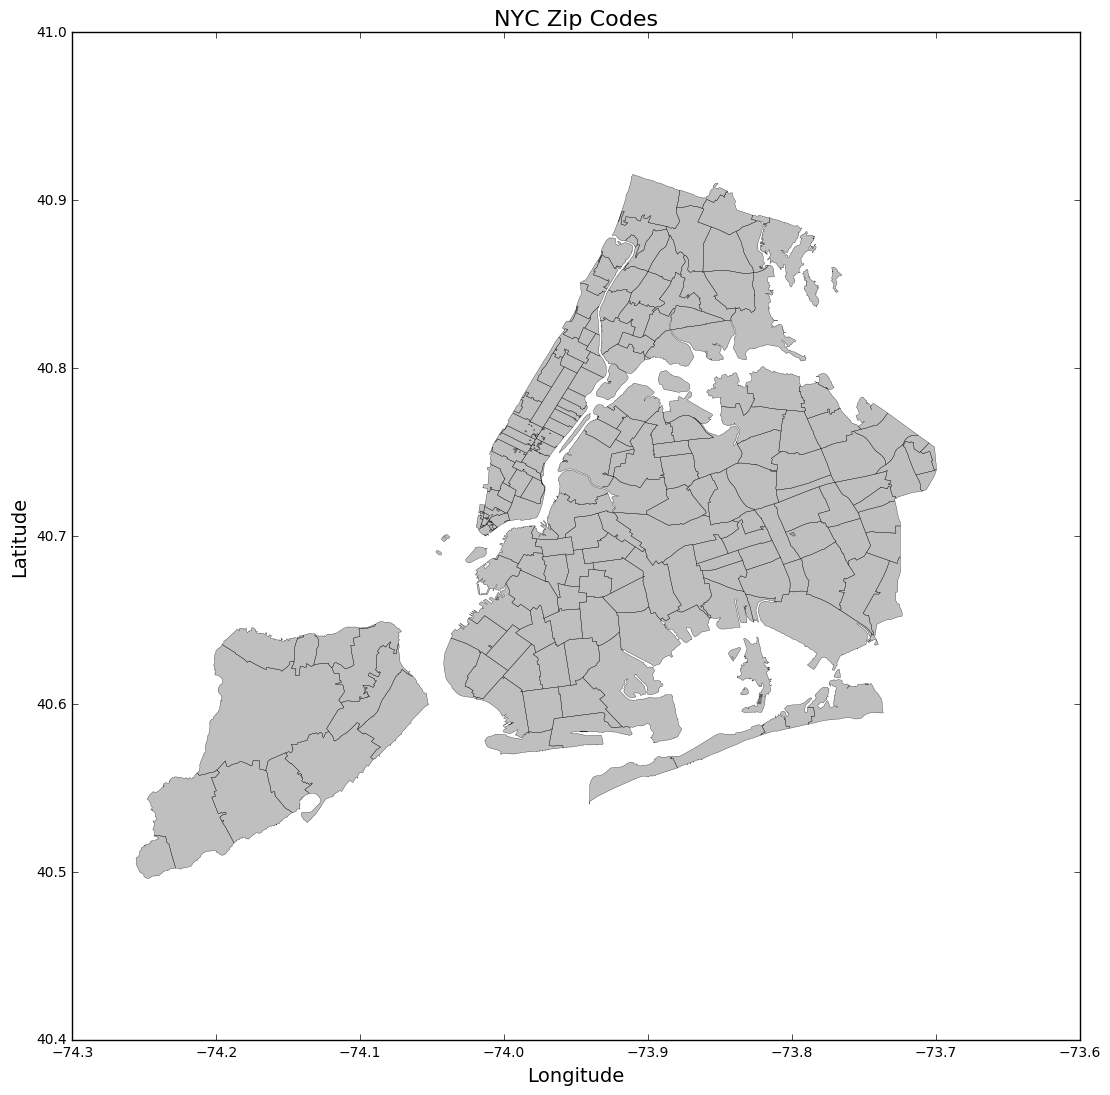

In [8]:
f, ax = pl.subplots(figsize=(13,13))

nyc_zip.plot(color='grey', linewidth=0.2, ax=ax)

ax.set_xlabel('Longitude', fontsize = 14)
ax.set_ylabel('Latitude', fontsize = 14)

pl.title('NYC Zip Codes', fontsize = 16)
pl.show()

** FIGURE 01: Zip Code divisions within New York City. **

### 1.c. Select only NYC business data and merge with Zip Code Shapes

In [9]:
i = 1998

fname = "zbp" + str(i)[2:] + "totals.zip"
zfi = zp.ZipFile(os.getenv("PUIDATA") + "/" + fname)
dfi = pd.read_csv(zfi.open(fname.replace('.zip','.txt')))

dfi.head()

,ZIP,NAME,EMPFLAG,EMP,QP1,AP,EST
0,501,"HOLTSVILLE, NY",NaN,2,11,57,3
1,1001,"AGAWAM, MA",NaN,7121,47926,215641,444
2,1002,"AMHERST, MA",NaN,6278,34435,154135,490
3,1003,"AMHERST, MA",NaN,86,535,2301,14
4,1004,"AMHERST, MA",NaN,172,811,4043,31


In [10]:
for i in range(1994,2015):
    fname = "zbp" + str(i)[2:] + "totals.zip"
    zfi = zp.ZipFile(os.getenv("PUIDATA") + "/" + fname)
    dfi = pd.read_csv(zfi.open(fname.replace('.zip','.txt')))
    
    dfi.rename(columns={"zip" : "zip_int", "ZIP" : "zip_int"}, inplace=True)
    dfi.set_index("zip_int", inplace=True)
    
    if i < 2010:
        nyc_zip = pd.merge(nyc_zip, pd.DataFrame(dfi.iloc[:,-1]) , how ='inner' , left_index=True, right_index=True)
        nyc_zip.rename(columns={"est": str(i), "EST": str(i)}, inplace=True)
        
    else:
        nyc_zip = pd.merge(nyc_zip, pd.DataFrame(dfi['est']) , how ='inner' , left_index=True, right_index=True)
        nyc_zip.rename(columns={"est": str(i)}, inplace=True)
    
    print i,
    
nyc_zip.head()

1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014

,zipcode,geometry,1994,1995,1996,1997,1998,1999,2000,2001,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip_int,,,,,,,,,,,,,,,,,,,,,
10001,10001,POLYGON ((-74.00827017711134 40.75258714368449...,6999,7088,7075,7154,7254,7233,7317,7188,...,7312,7415,7549,7472,7305,7241,7227,7235,7273,7369
10002,10002,POLYGON ((-73.97441674489379 40.73642441865476...,1784,1819,1919,2049,2003,2085,2277,2543,...,2682,2686,2685,2691,2775,2872,2912,2954,2988,2972
10003,10003,POLYGON ((-73.97986374196766 40.73497446573838...,3256,3377,3417,3535,3649,3659,3683,3602,...,3867,3909,4049,4071,4099,4113,4159,4214,4277,4333
10004,10004,"POLYGON ((-74.00596661578348 40.7043243225291,...",1115,1124,1133,1173,1176,1233,1294,1247,...,1260,1311,1370,1376,1379,1398,1404,1442,1479,1554
10004,10004,POLYGON ((-74.04166368343016 40.69644987183209...,1115,1124,1133,1173,1176,1233,1294,1247,...,1260,1311,1370,1376,1379,1398,1404,1442,1479,1554


In [11]:
nyc_zip.columns

Index([u'zipcode', u'geometry', u'1994', u'1995', u'1996', u'1997', u'1998',
       u'1999', u'2000', u'2001', u'2002', u'2003', u'2004', u'2005', u'2006',
       u'2007', u'2008', u'2009', u'2010', u'2011', u'2012', u'2013', u'2014'],
      dtype='object')

In [12]:
nyc_zip.describe()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,...,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,786.374486,801.930041,812.234568,832.506173,843.716049,850.288066,864.934156,865.695473,875.000000,885.600823,...,906.395062,911.337449,913.864198,919.263374,923.489712,937.012346,948.156379,964.320988,982.485597,997.716049
std,1142.732854,1170.402664,1173.207861,1198.182206,1208.995347,1207.629794,1229.229795,1234.064543,1196.521024,1196.590739,...,1223.284020,1230.869951,1216.140601,1212.799049,1196.968869,1198.395461,1203.064486,1215.016806,1226.610540,1236.510051
min,1.000000,1.000000,2.000000,2.000000,3.000000,2.000000,4.000000,5.000000,5.000000,5.000000,...,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000,2.000000,3.000000,4.000000,4.000000
25%,169.500000,178.000000,178.000000,180.000000,185.500000,185.000000,192.500000,190.000000,200.500000,208.000000,...,191.500000,195.000000,183.000000,190.000000,203.000000,190.500000,187.000000,186.500000,184.000000,179.000000
50%,438.000000,448.000000,457.000000,472.000000,482.000000,482.000000,490.000000,491.000000,525.000000,534.000000,...,536.000000,541.000000,538.000000,545.000000,560.000000,580.000000,597.000000,612.000000,630.000000,638.000000
75%,896.000000,903.000000,937.000000,940.500000,950.000000,955.000000,953.000000,951.000000,989.500000,996.000000,...,1034.500000,1019.000000,1043.000000,1061.500000,1073.000000,1095.500000,1115.000000,1157.000000,1198.500000,1237.000000
max,6999.000000,7088.000000,7075.000000,7154.000000,7254.000000,7233.000000,7317.000000,7188.000000,7141.000000,7084.000000,...,7312.000000,7415.000000,7549.000000,7472.000000,7305.000000,7241.000000,7227.000000,7235.000000,7273.000000,7369.000000


### 1d. Whitening the data

In [13]:
nyc_zip_w = nyc_zip

for i in range(len(nyc_zip)):
    nyc_zip_w.iloc[i,2:] = (nyc_zip.iloc[i,2:] - nyc_zip.iloc[i,2:].mean())/nyc_zip.iloc[i,2:].std()
    
nyc_zip_w.shape

(243, 23)

In [14]:
nyc_zip_w.describe()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,...,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,-1.009820,-0.900371,-0.804548,-0.651203,-0.560743,-0.463980,-0.349822,-0.327877,-0.180408,-0.085442,...,0.170685,0.190658,0.277438,0.310202,0.360346,0.491133,0.569032,0.750864,0.949309,1.140232
std,1.116464,0.938837,0.812842,0.753154,0.775382,0.774400,0.799265,0.741319,0.553115,0.584720,...,0.538337,0.540521,0.542232,0.560468,0.587235,0.718749,0.842238,0.924538,1.000787,1.092847
min,-3.459962,-2.367927,-1.897567,-1.892837,-2.054090,-1.821346,-2.105643,-1.666750,-1.841075,-1.760021,...,-1.478227,-1.910232,-1.559909,-1.435979,-1.696628,-1.649178,-2.113009,-2.020149,-1.827710,-2.019528
25%,-1.645204,-1.470869,-1.319671,-1.090628,-1.002660,-0.929749,-0.831585,-0.760883,-0.463519,-0.379639,...,-0.093326,-0.011155,0.076569,0.087489,0.170918,0.282918,0.358136,0.477327,0.600566,0.778599
50%,-1.322172,-1.207515,-1.105014,-0.926456,-0.816361,-0.732544,-0.610926,-0.566623,-0.235929,-0.131412,...,0.157177,0.223560,0.327569,0.409915,0.512900,0.744276,0.917255,1.165268,1.374920,1.613328
75%,-0.710121,-0.710477,-0.697991,-0.536456,-0.349955,-0.189823,-0.119517,-0.112660,-0.000853,0.175459,...,0.467819,0.513556,0.580074,0.636179,0.690089,0.948360,1.098092,1.375872,1.619954,1.844668
max,3.212291,2.228009,2.216083,1.698668,2.040039,2.143528,2.576381,2.705124,2.144307,2.655893,...,2.285662,1.397476,2.152288,1.781514,1.845008,1.505138,1.738911,2.405536,2.216690,3.406371


In [15]:
#double checking
nyc_zip_w.iloc[:,2:].mean(1).head()

zip_int
10001   -9.251859e-16
10002    2.220446e-16
10003   -5.286776e-17
10004   -1.691768e-16
10004   -1.691768e-16
dtype: float64

In [16]:
nyc_zip_w.iloc[:,2:].std(1).head()

zip_int
10001    1.0
10002    1.0
10003    1.0
10004    1.0
10004    1.0
dtype: float64

### 2. Clustering the number of establishments with K-means

In [17]:
X=nyc_zip_w.iloc[:,2:]
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=247)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.572142801777
For n_clusters =3, the average silhouette_score is :0.541072613328
For n_clusters =4, the average silhouette_score is :0.495601550463
For n_clusters =5, the average silhouette_score is :0.331788097115
For n_clusters =6, the average silhouette_score is :0.315870202297
For n_clusters =7, the average silhouette_score is :0.320393719852
For n_clusters =8, the average silhouette_score is :0.192395170717
For n_clusters =9, the average silhouette_score is :0.156228558808


The silhouette method assess which would be the optimal K by testing how close the points are from their cluster center in relatio to the next closer one.
From the tes we can observe that apparently the best number of clusters is 2. 

In [18]:
# function we used in the Applied Data Science class

def elbow(data,K):
    """
    Function that calculates and plots the average sum of square distances within cluster for different values of
    K in order to help assess which one is the best K through the so called elbow method.
    data: input as numpy form.
    K : a list of number of clusters we want to test.   
    """

    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = pl.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    pl.grid(True)
    pl.xlabel('Number of clusters')
    pl.ylabel('Average within-cluster sum of squares')
    pl.title('Elbow for KMeans clustering')
    pl.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = pl.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    pl.grid(True)
    pl.xlabel('Number of clusters')
    pl.ylabel('Percentage of variance explained')
    pl.title('Elbow for KMeans clustering')
    pl.show()

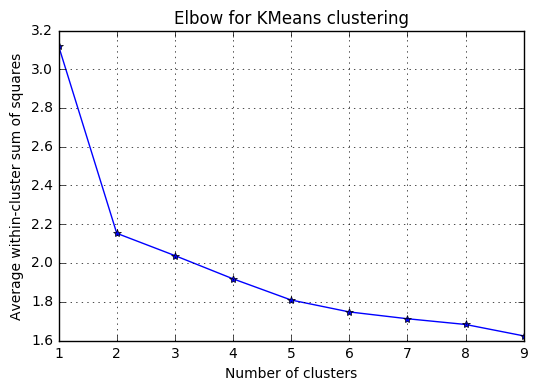

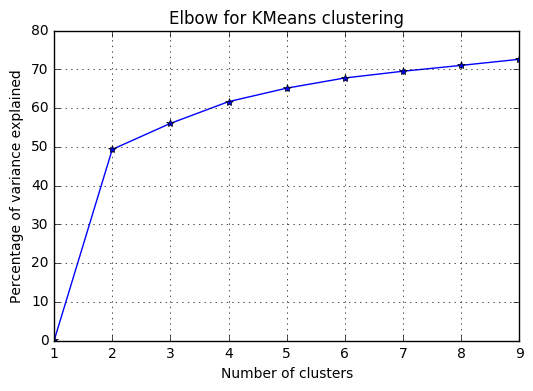

In [19]:
elbow(X, range(1,10))

** FIGURE 02: the results of the elbow method seem also to indicate that the most adequate number of clusters is 2. Nevertheless, the percentage of variance explained by two cluster is only about 50% of the total variance, and since the percentage of explained variance keeps increasing in a relatively significnt way, it would be also justifiable to try the clustering with a K higher than 2. ** 

In [20]:
# clustering with K-means for K=2

km = KMeans(n_clusters=2, random_state=247)
labels = km.fit_predict(X)


### 3. Ploting the centroids of each cluster

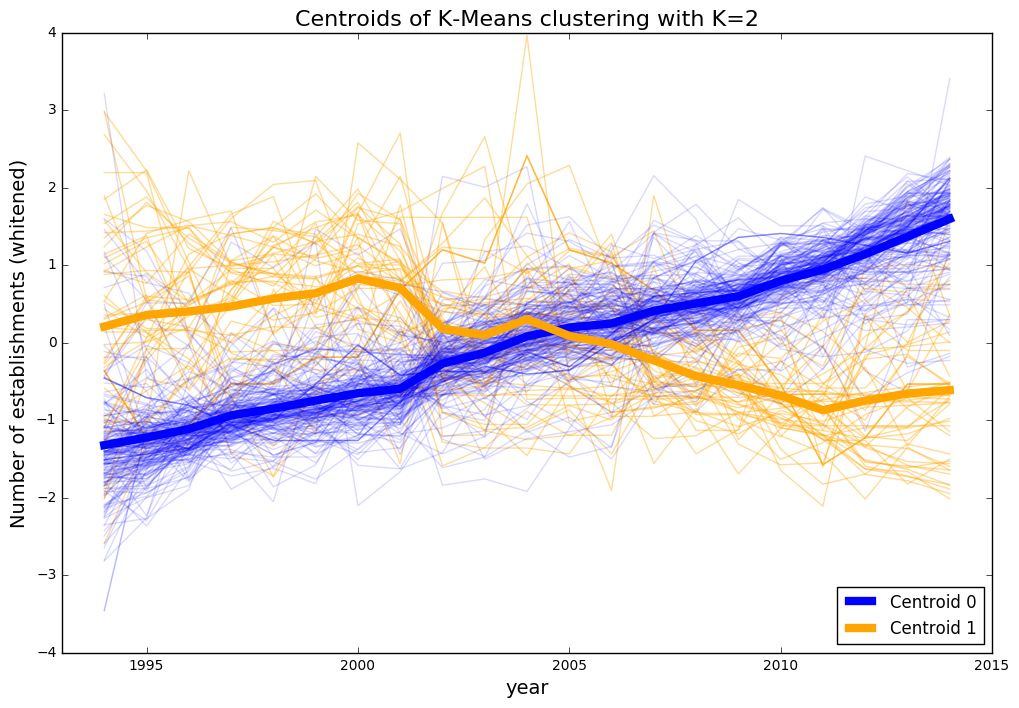

In [21]:
fig = pl.figure(figsize=(12, 8))

pl.plot(X.columns, np.array(X[labels==1]).T, color='orange', alpha=0.4)
pl.plot(X.columns, np.array(X[labels==0]).T, color='blue', alpha=0.15)
pl.plot(X.columns, np.average(X, axis=0, weights=~labels.astype('bool')), linewidth=6 , color='blue', label = 'Centroid 0')
pl.plot(X.columns, np.average(X, axis=0, weights=labels.astype('bool')), linewidth=6 , color='orange', label = 'Centroid 1')
pl.xlim(1993,2015)
pl.legend(loc='best')
pl.xlabel('year', fontsize=14)
pl.ylabel('Number of establishments (whitened)', fontsize=14)
pl.title('Centroids of K-Means clustering with K=2', fontsize=16)

pl.show()
#@Review: 
#step two requires more than a couple of clusters

** FIGURE 03: Plot showing the resulting centroids for the K-means clustering with K=2. It is evident that one cluster represents zipcodes that have, on average, significantly increased their establishments during the 2000s, and the other one represents the zipcodes that have in general faced a decrease in establishments during that period. **  

## 4. Clustering with Gaussian Mixture

In [22]:
gm=GMM(n_components=2,random_state=247)
res = gm.fit(X)
labels2 = res.predict(X)

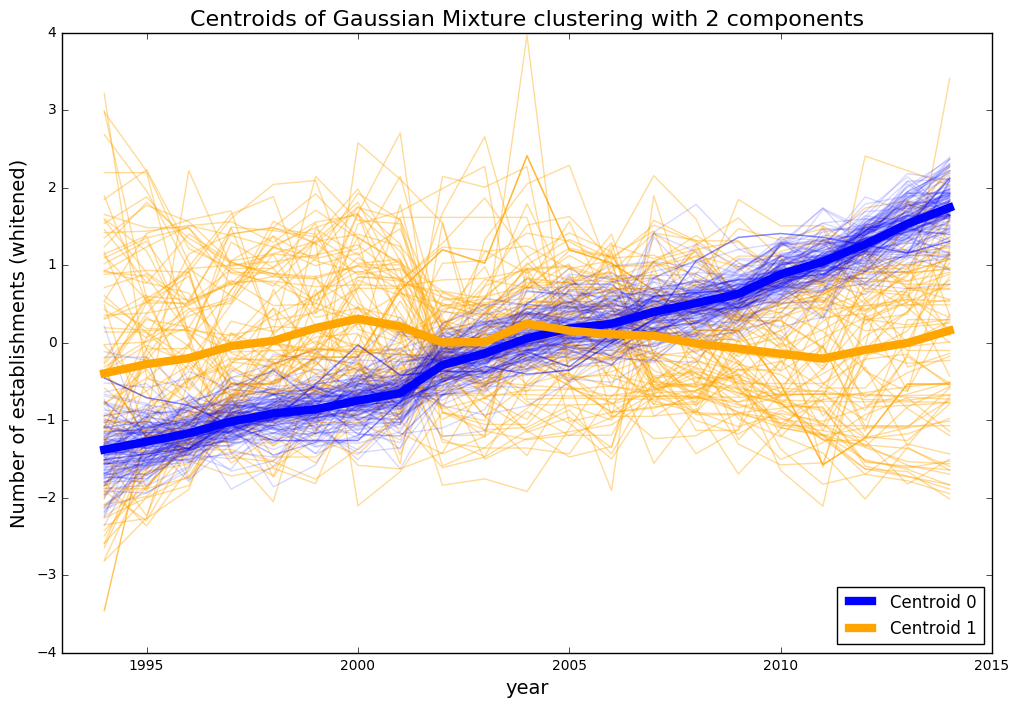

In [23]:
# plotting the result with Gaussian Mixture

fig = pl.figure(figsize=(12, 8))

pl.plot(X.columns, np.array(X[labels2==1]).T, color='orange', alpha=0.4)
pl.plot(X.columns, np.array(X[labels2==0]).T, color='blue', alpha=0.15)
pl.plot(X.columns, np.average(X, axis=0, weights=~labels2.astype('bool')), linewidth=6 , color='blue', label = 'Centroid 0')
pl.plot(X.columns, np.average(X, axis=0, weights=labels2.astype('bool')), linewidth=6 , color='orange', label = 'Centroid 1')
pl.xlim(1993,2015)
pl.legend(loc='best')
pl.xlabel('year', fontsize=14)
pl.ylabel('Number of establishments (whitened)', fontsize=14)
pl.title('Centroids of Gaussian Mixture clustering with 2 components', fontsize=16)

pl.show()


** FIGURE 04: Plot showing the resulting centroids for the Guassian Mixture Model clustering with 2 components. Comparing with the K-means algorithm we can see that the result is significantly different. Since the mixture model is more flexible and allows for sobreposition of distributions, that is exacty what happens in this case. Because cluster 1 has a larger variance, some timeseries end up being allocated to it even if their distance to the other centroid is smaller. Then we have a much differente result than in FIGURE 03, since the centroid 1, in this case, has not a decrease trend, but is rather more stagnant. **

## 5. Plotting the results of the clusterings on the map.

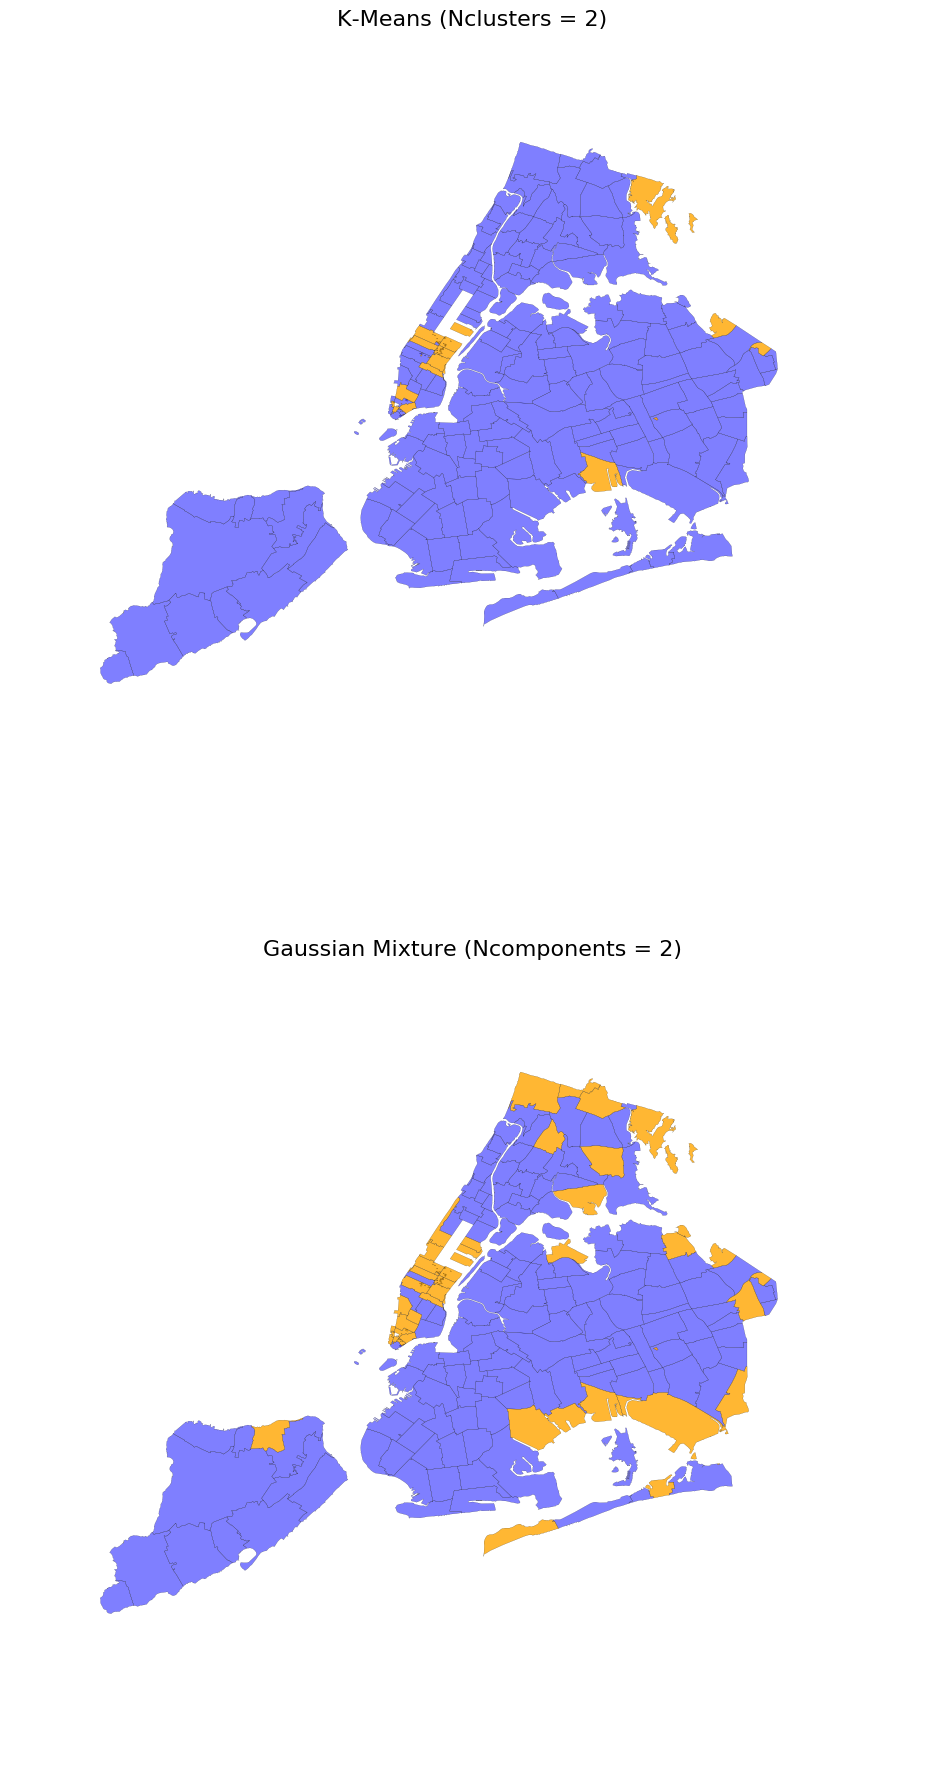

In [24]:
f, (ax1, ax2) = pl.subplots(2, 1, sharex=True, figsize=(11,22))
# ax1.get_xaxis().set_visible(False)
# ax1.get_yaxis().set_visible(False)
# ax2.get_xaxis().set_visible(False)
# ax2.get_yaxis().set_visible(False)
ax1.set_axis_off()
ax2.set_axis_off()

nyc_zip_w[labels==0].plot(color='blue',alpha=0.5,linewidth=0.1,ax=ax1)
nyc_zip_w[labels==1].plot(color='orange',alpha=0.8,linewidth=0.1,ax=ax1)
nyc_zip_w[labels2==0].plot(color='blue',alpha=0.5,linewidth=0.1,ax=ax2)
nyc_zip_w[labels2==1].plot(color='orange',alpha=0.8,linewidth=0.1,ax=ax2)


ax1.set_title("K-Means (Nclusters = 2)", fontsize=16)
ax2.set_title("Gaussian Mixture (Ncomponents = 2)", fontsize=16)

pl.show()

** FIGURE 05: Maps of the clusters obtained through K-means and Gaussian Mixture algorithms. The K-means result points out the midtown and extreme south of Manhattan in cluster 0, together with some more distant regions of the Bronx. In FIGURE 03 we can see that for this cluster the average trend (the centroid) was a slight increase in the 1990s and in the 2010s with a fairly significant decrease in the 2000s. But for this group he signal was also very noisy. The Gaussian Mixture points to a similar result, but expands the area covered by cluster 0. That occurs because of the rather noisy nature of the signal (timeseries) for cluster 0. **

## 6. Compare the two algoritms

Both algorithms pointed to a similar result, although the Guassian Mixture model included a larger area in the stagnant group with the counterbalance of having a centroid with a more stangnant trend compared to the more acentuated decrease in the K-means result. 

## 7. Interpretation

It seems that the regions that are more stagnant can be still split into two very different groups. While in Manhattan, the reason behind this stagnation is probably related to the saturation of the region for the instalation of more business, in the further regions of the Bronx, it is more likely that the reason ther is associated with a lower level of economic development in those areas.
The fact the the signal for cluster 0 is very noisy, can also be an indicator that there are very distinct patterns in that group. But on the other hand, it makes us wonder if we do not have to do a little more cleaning in the data, before proceed with our analysis. 